## Pre-Training on unlabelled data



we implement the training loop and code for basic model evaluation to pretrain an LLM

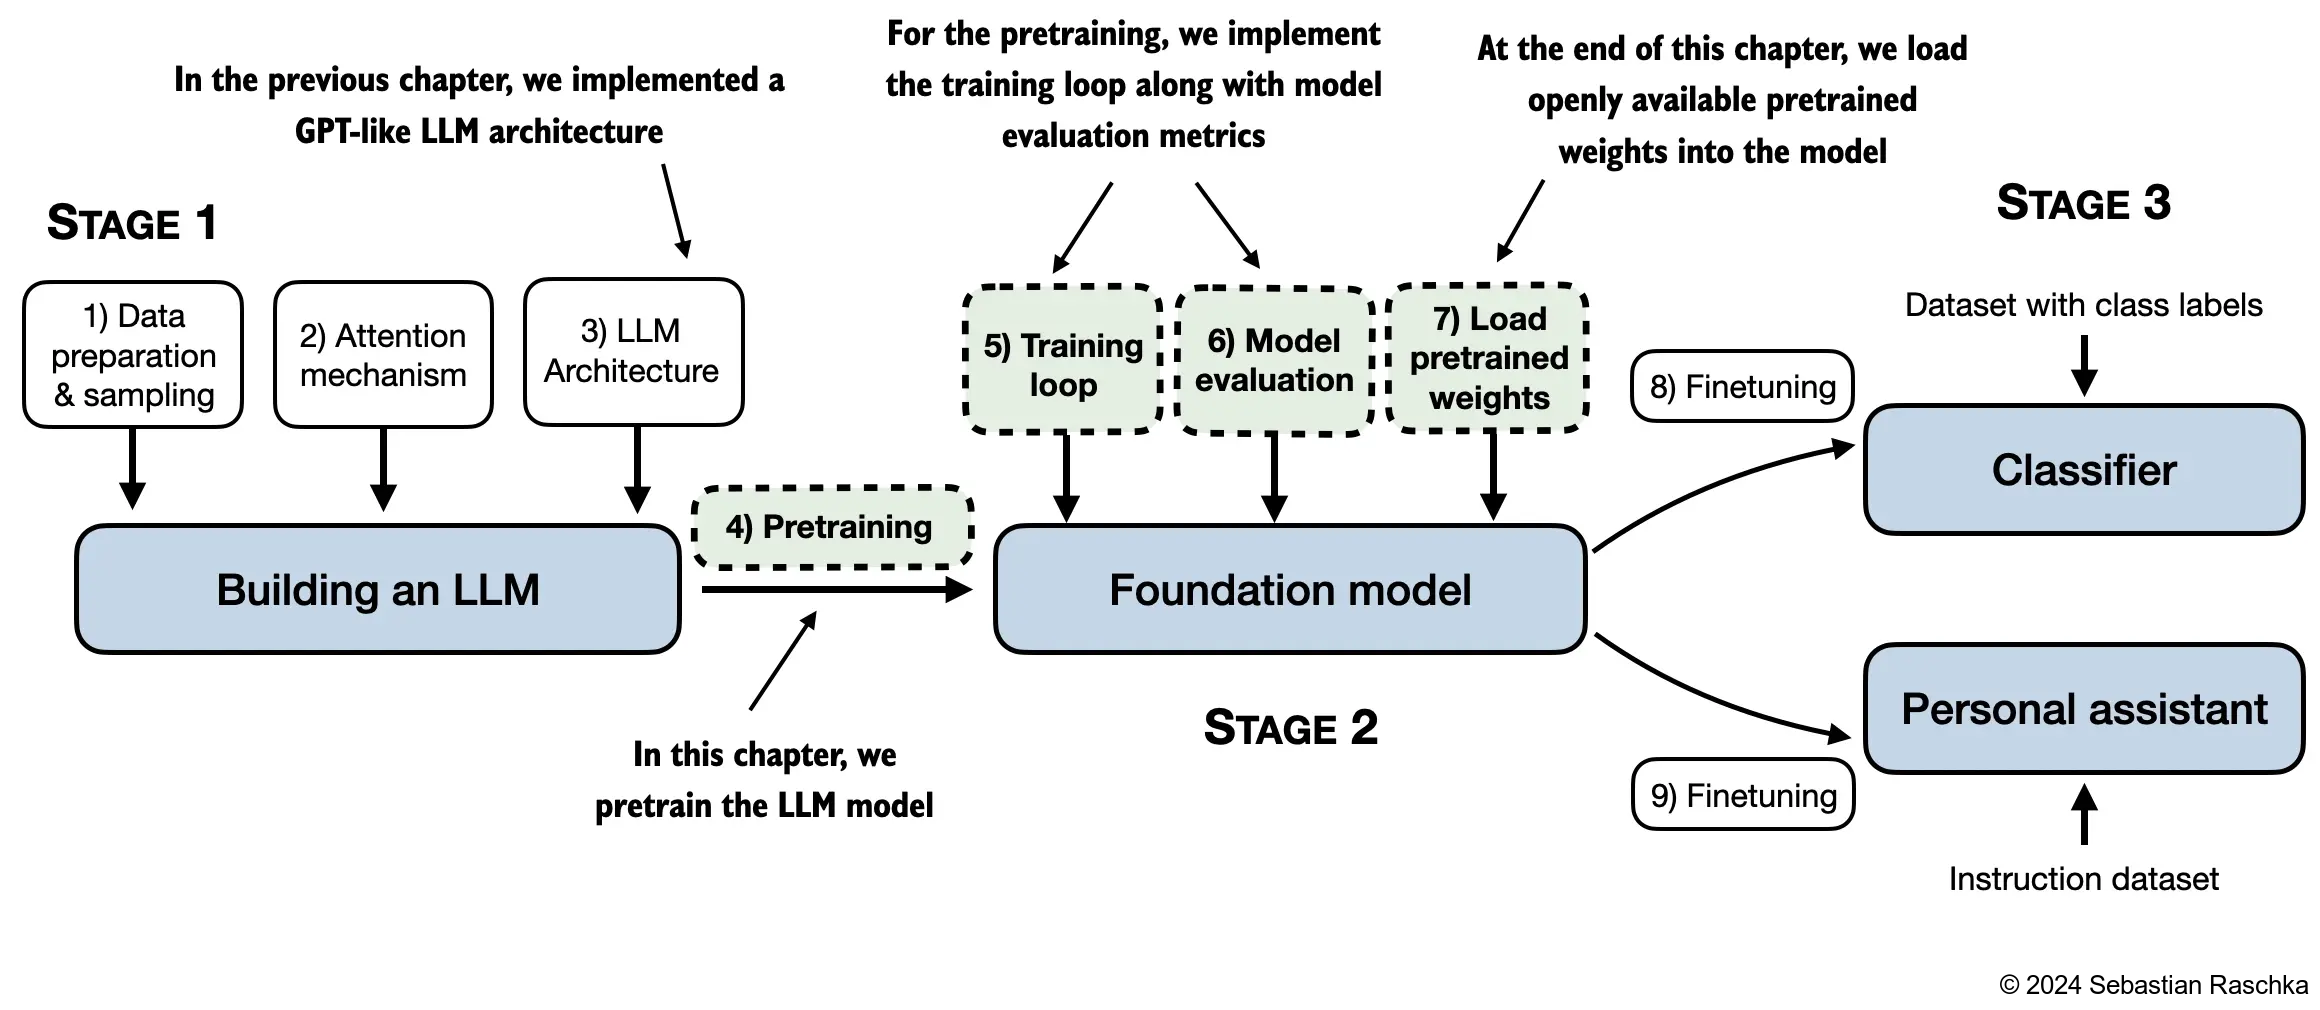

**Evaluating generative text models**

Using GPT to generate text

In [1]:
import torch
from previous_chapters import GPTModel
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch04 import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

* Vocabulary size: 50,257 tokens (based on GPT-2’s tokenizer).
* Context length: 256 tokens (reduced from 1024 to save memory).
* Embedding dimension: 768 (size of token embeddings).
* Number of attention heads: 12.
* Number of layers: 12.
* Dropout rate: 0.1 (though modern LLMs often skip dropout).
* QKV bias: Set to False (modern LLMs avoid bias in query, key, value matrices)

The model is set to evaluation mode `(model.eval())` to disable dropout during inference.

##  Model has 12 TransformerBlock layer

In [2]:
len(model.trf_blocks)

12

## Single TransfornerBlock layer

In [3]:
model.trf_blocks[0]

TransformerBlock(
  (att): MultiHeadAttention(
    (W_query): Linear(in_features=768, out_features=768, bias=False)
    (W_key): Linear(in_features=768, out_features=768, bias=False)
    (W_value): Linear(in_features=768, out_features=768, bias=False)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ff): FeedForward(
    (layers): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU()
      (2): Linear(in_features=3072, out_features=768, bias=True)
    )
  )
  (norm1): LayerNorm()
  (norm2): LayerNorm()
  (drop_shortcut): Dropout(p=0.1, inplace=False)
)

# **GPTModel Architecture**

> A transformer-based language model with **12 identical TransformerBlock layers**.

---

### **Embedding Layers**

- **tok_emb**: `Embedding(50257, 768)`  
  Embeds token IDs into 768-dimensional vectors.
- **pos_emb**: `Embedding(256, 768)`  
  Encodes positional information into the same dimensionality.
- **drop_emb**: `Dropout(p=0.1)`  
  Prevents overfitting on embeddings.

---

### **Transformer Blocks**

**trf_blocks**: `Sequential` of 12 identical `TransformerBlock`s:  
Each block contains:

#### ▶ TransformerBlock
- **att**: `MultiHeadAttention`
  - `W_query`: `Linear(768 → 768, bias=False)`
  - `W_key`: `Linear(768 → 768, bias=False)`
  - `W_value`: `Linear(768 → 768, bias=False)`
  - `out_proj`: `Linear(768 → 768, bias=True)`
  - `dropout`: `Dropout(p=0.1)`

- **ff**: `FeedForward`
  - `layers`: `Sequential`
    1. `Linear(768 → 3072)`
    2. `GELU()`
    3. `Linear(3072 → 768)`

- **norm1**: `LayerNorm()`  
- **norm2**: `LayerNorm()`  
- **drop_shortcut**: `Dropout(p=0.1)`

> 🔁 This structure is **repeated for 12 layers**:  


In [4]:
import tiktoken
from previous_chapters import generate_text_simple

# Alternatively:
# from llms_from_scratch.ch04 import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


**Calculating the text generation loss: cross-entropy and perplexity**

* Suppose we have an `inputs` tensor containing the token IDs for 2 training examples (rows)
* Corresponding to the `inputs`, the `targets` contain the desired token IDs that we want the model to generate
* Notice that the `targets` are the `inputs` shifted by `1 position`, as explained" when we implemented the data loader

In [5]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

* Feeding the inputs to the model, we obtain the logits vector for the `2 input` examples that consist of `3 tokens` each
* Each of the tokens is a `50,257-dimensional` vector corresponding to the size of the vocabulary
* Applying the `softmax function`, we can turn the `logits tensor` into a tensor of the same dimension containing probability scores

In [6]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


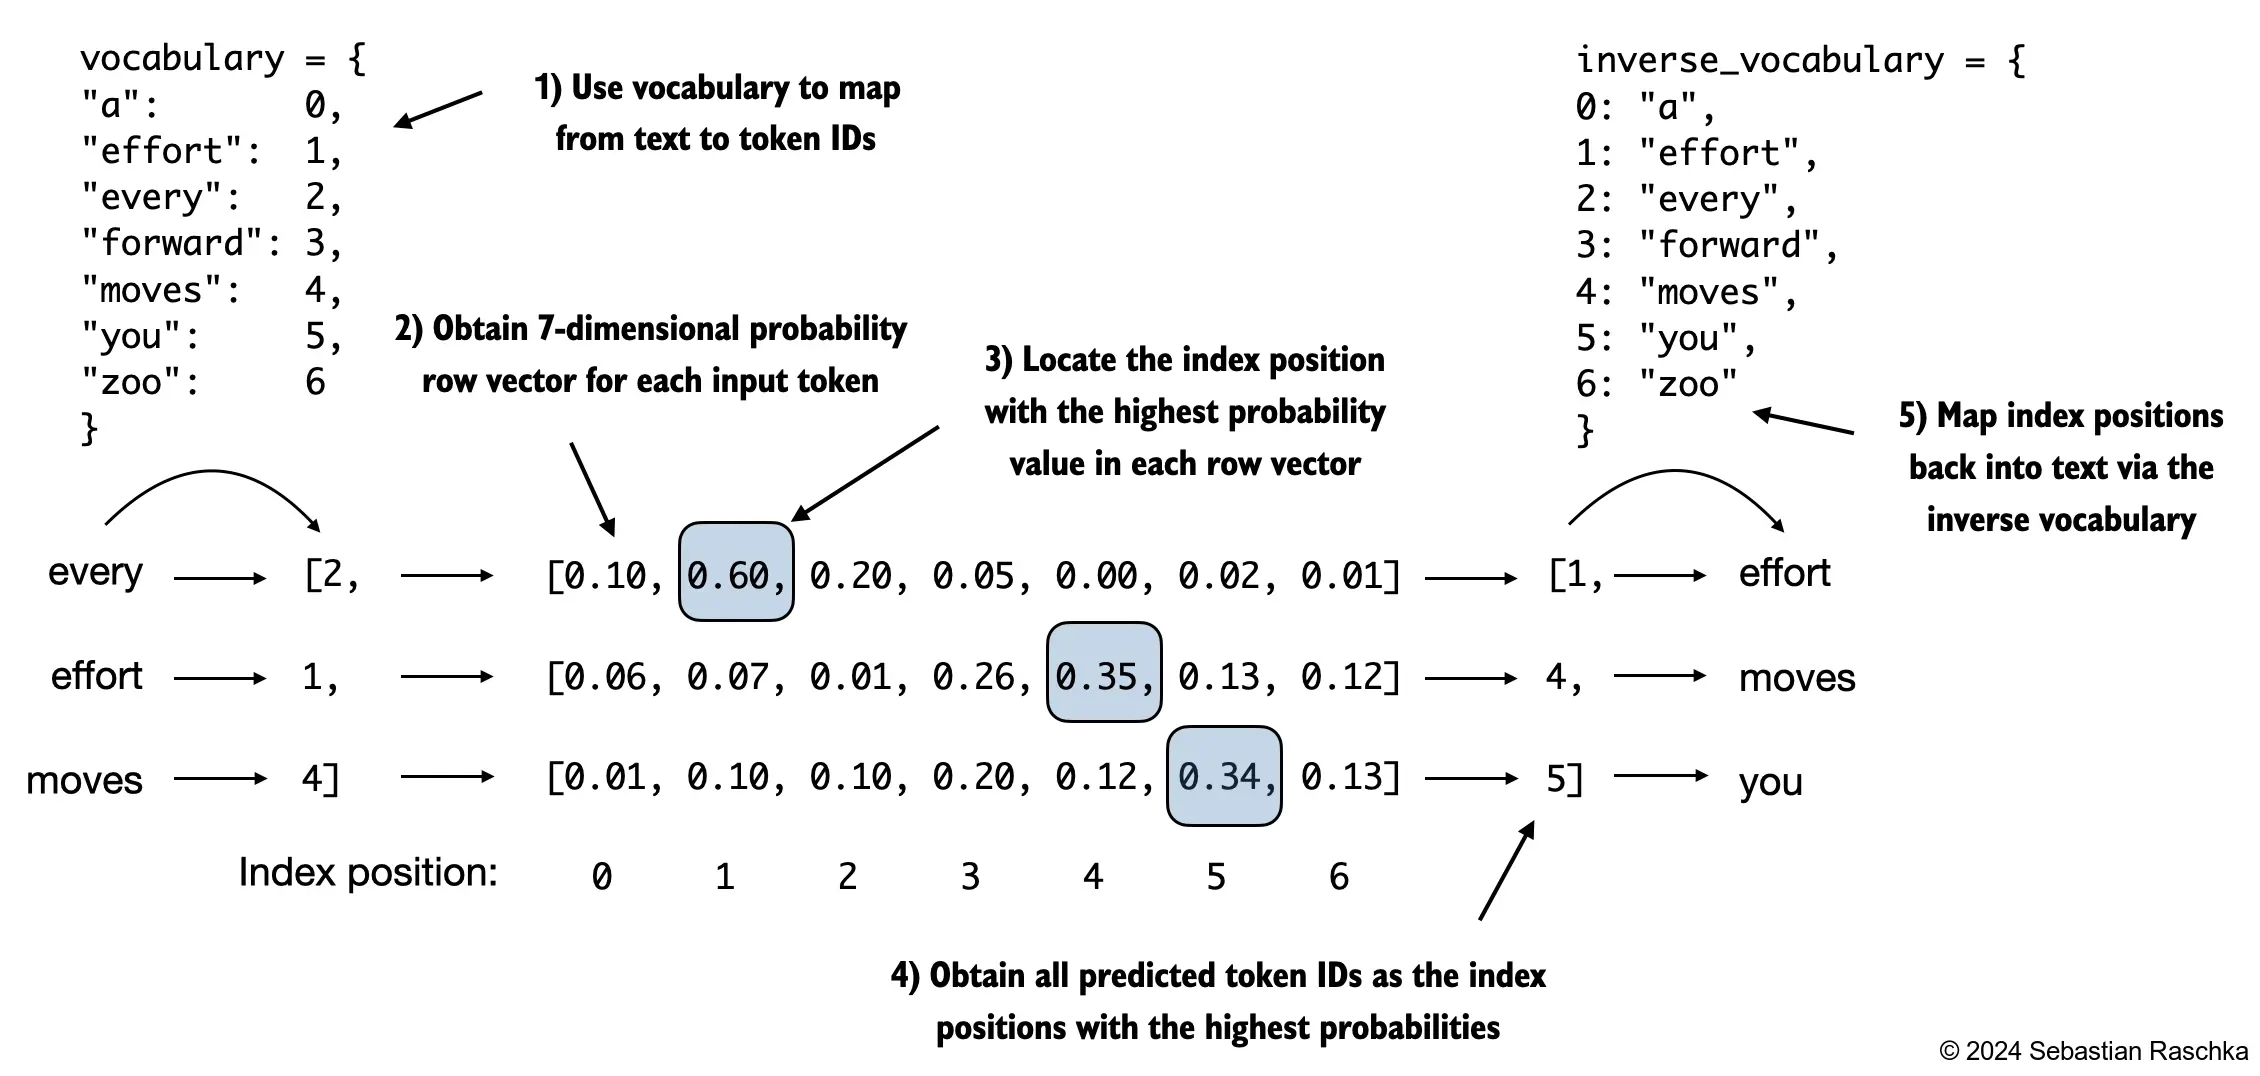

we can apply the argmax function to convert the probability scores into predicted token IDs

The softmax function above produced a `50,257-dimensional` vector for each token; the `argmax` function returns the position of the highest probability score in this vector, which is the predicted token ID for the given token

Since we have 2 input batches with 3 tokens each, we obtain 2 by 3 predicted token IDs:

In [7]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [8]:
# start_context = "Every effort moves you"

print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


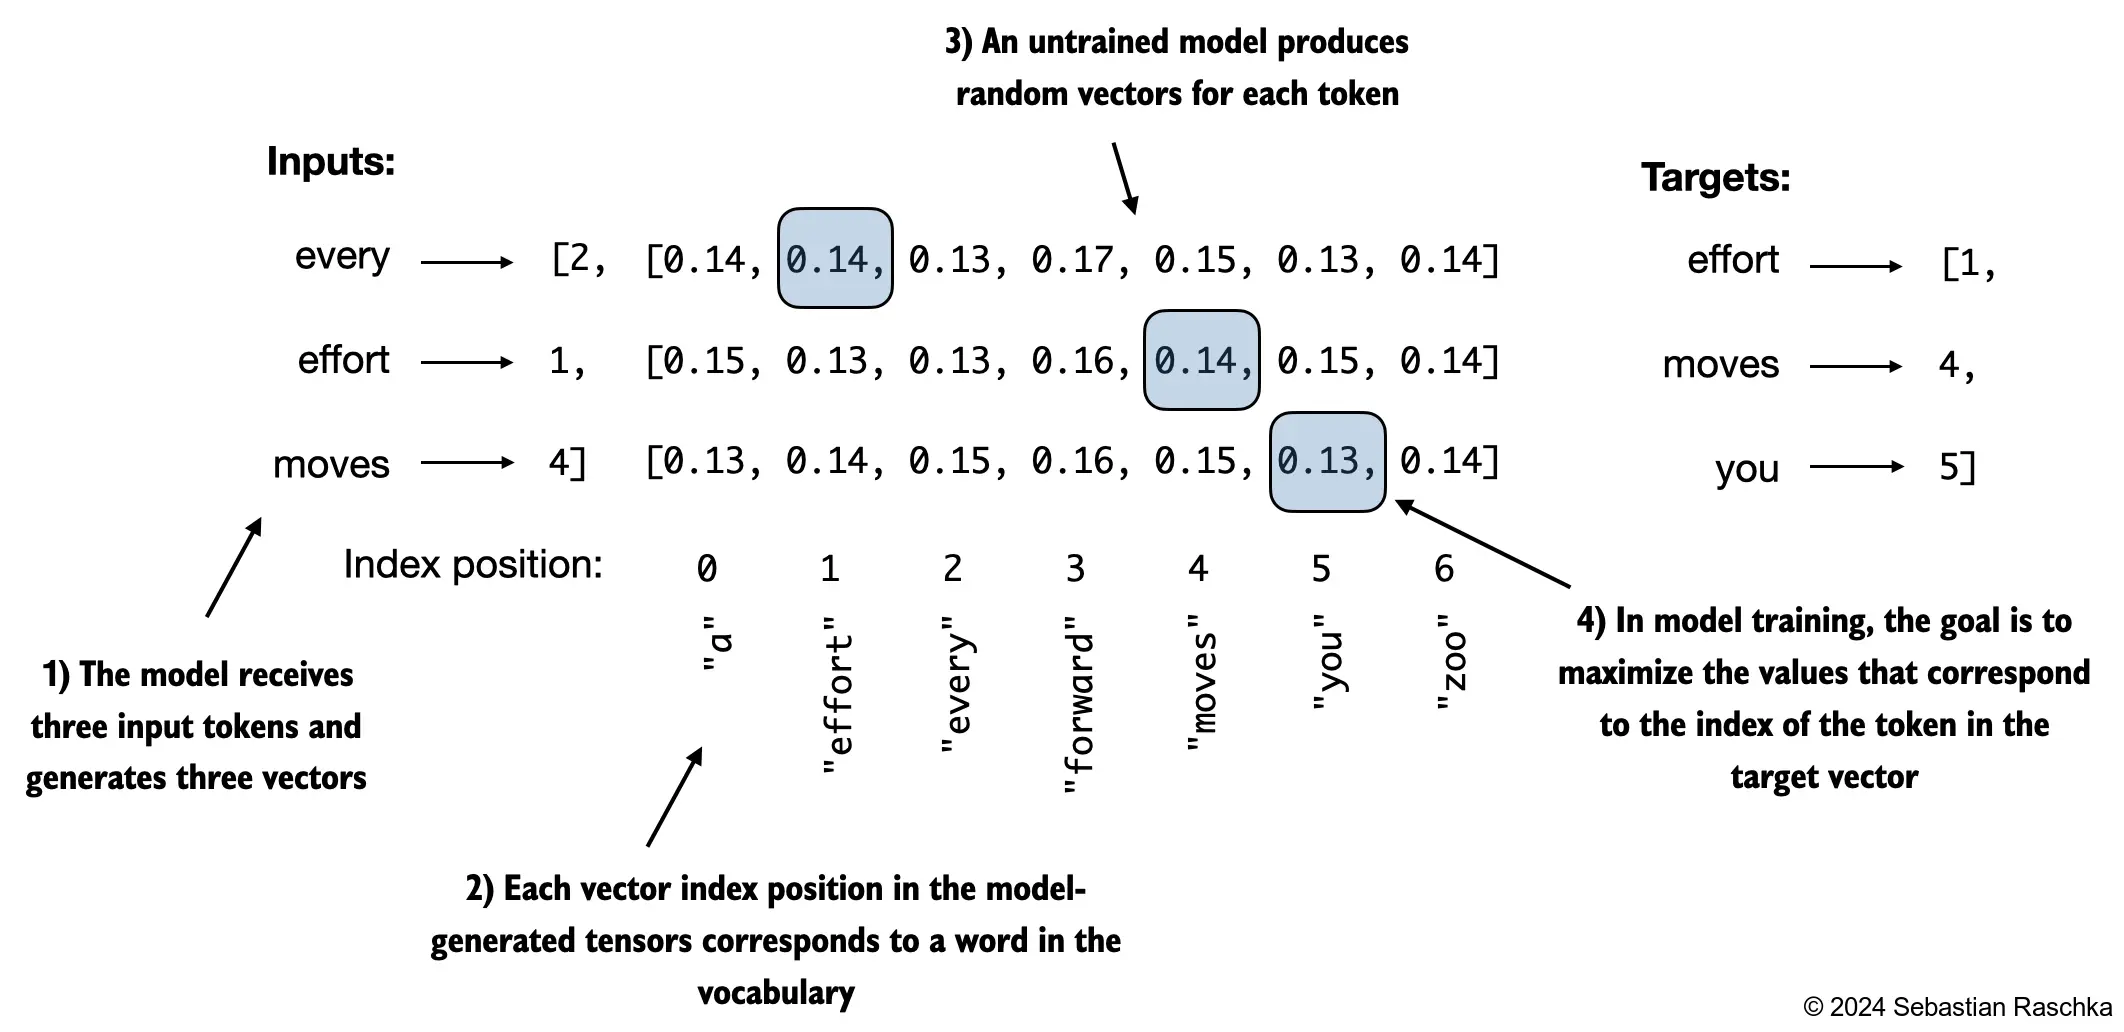

The token probabilities corresponding to the target indices are as follows:

In [9]:
probas.shape

torch.Size([2, 3, 50257])

In [10]:
targets

tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])

In [11]:
probas[0].shape

torch.Size([3, 50257])

> text_idx = 0:

Selects the first input sequence (batch index 0, corresponding to "every effort moves").

In [12]:
targets

tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])

* For token position 0: Probability of `token ID 3626` ("effort")
* For token position 1: Probability of `token ID 6100` ("moves").
* For token position 2: Probability of `token ID 345` ("you").

In [13]:
# target token ke index ka probs nikala ja rha h
# from the predicted probs se
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


We want to maximize all these values, bringing them close to a probability of 1

In mathematical optimization, it is easier to maximize the logarithm of the probability score than the probability score itself

In [14]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


Next, we compute the average log probability:

# Calculate the average probability for each token

In [15]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


* The goal is to make this average log probability as large as possible by optimizing the model weights
* Due to the log, the largest possible value is 0, and we are currently far away from 0
* In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the negative average log-probability value; in our case, instead of maximizing -10.7722 so that it approaches 0, in deep learning, we would minimize 10.7722 so that it approaches 0
* The value negative of -10.7722, i.e., 10.7722, is also called cross-entropy loss in deep learning

In [16]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


PyTorch already implements a cross_entropy function that carries out the previous steps

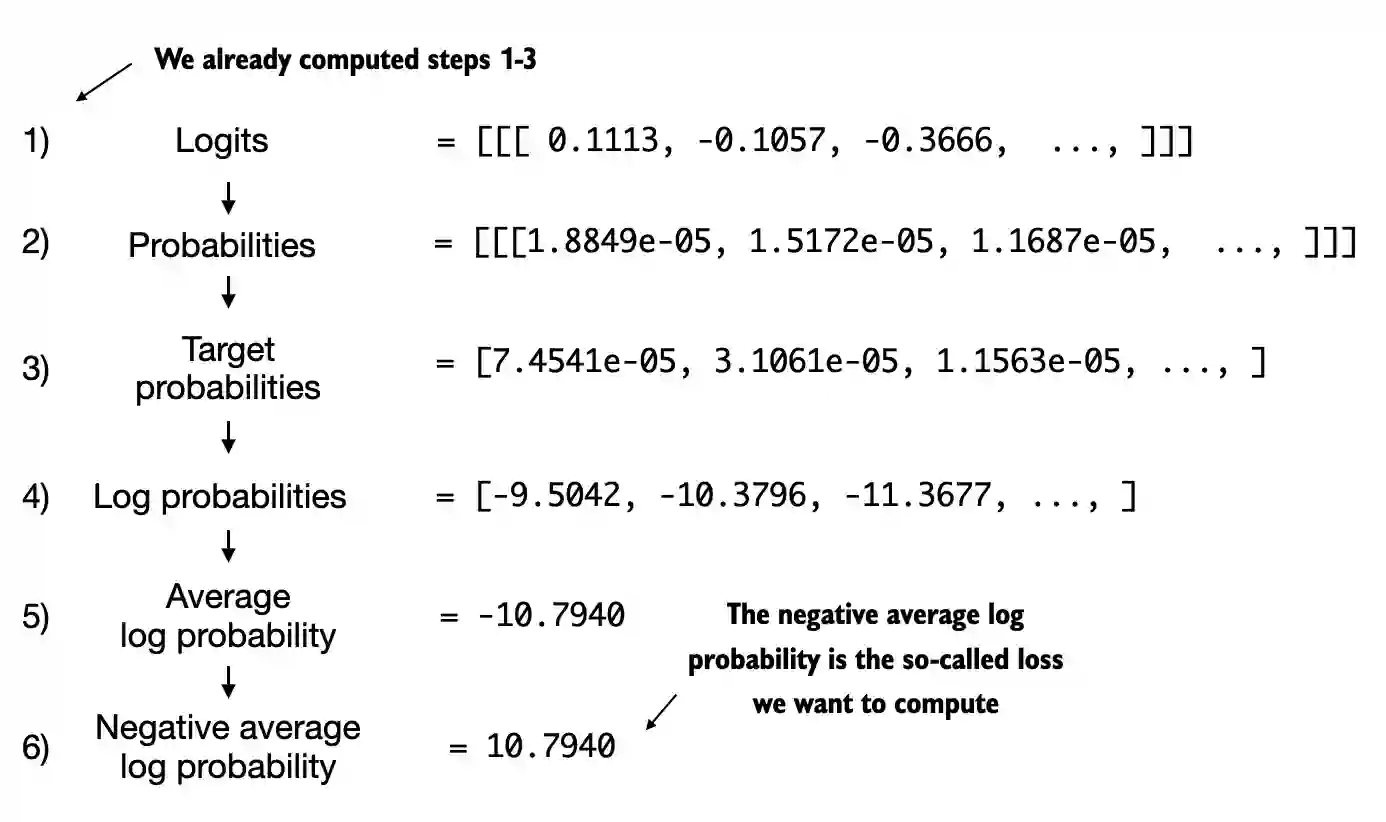

Before we apply the cross_entropy function, let's check the shape of the logits and targets

In [17]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


For the cross_entropy function in PyTorch, we want to flatten these tensors by combining them over the batch dimension:

In [18]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


* Note that the targets are the token IDs, which also represent the index positions in the logits tensors that we want to maximize
* The `cross_entropy` function in PyTorch will automatically take care of applying the softmax and log-probability computation internally over those token indices in the logits that are to be maximized

In [19]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


* A concept related to the cross-entropy loss is the perplexity of an LLM
* The perplexity is simply the exponential of the cross-entropy loss

$$Perplexity = e^{CrossEntropyLoss}$$$$Perplexity = e^{CrossEntropyLoss}$$

In [20]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


> The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be `48,725 words` or tokens)

> In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset

* Similar to the loss, a **`lower perplexity`** indicates that the model predictions are closer to the actual distribution

**Calculating the training and validation set losses**

In [21]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [22]:
# First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [23]:
# Last 100 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [24]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


 we divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training

> For visualization purposes, the figure below assumes a max_length=6, but for the training loader, we set the max_length equal to the context length that the LLM supports

> The figure below only shows the input tokens for simplicity
Since we train the LLM to predict the next word in the text, the targets look the same as these inputs, except that the targets are shifted by one position

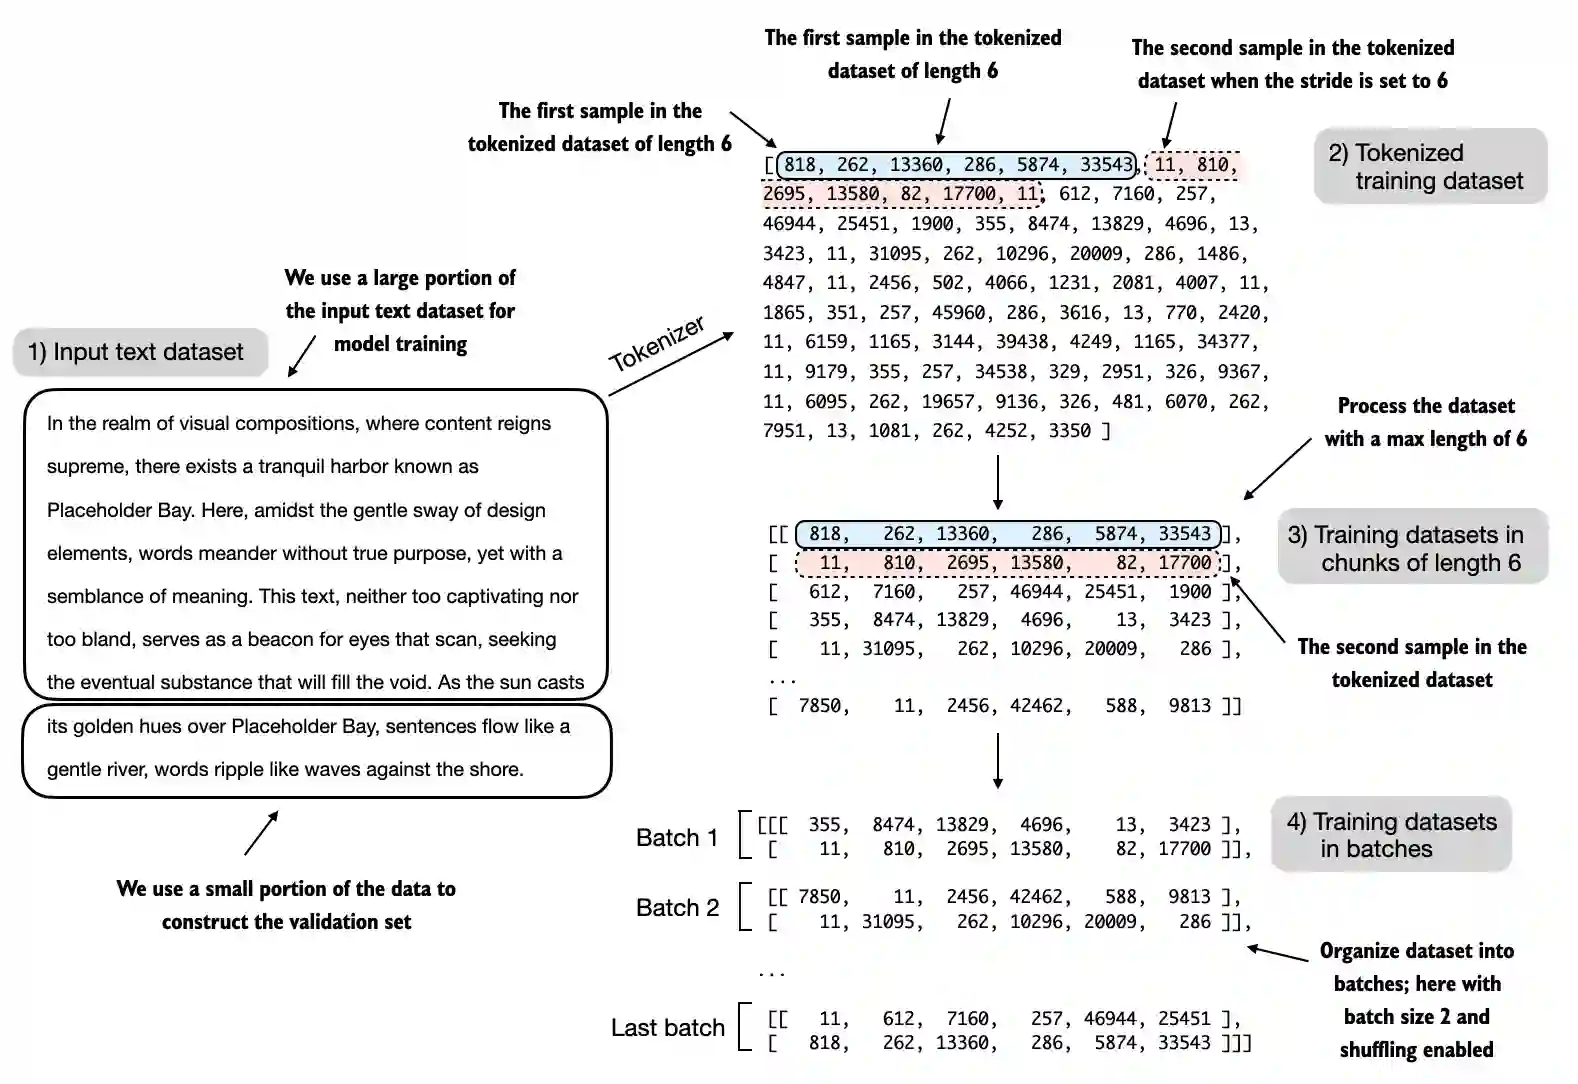

In [25]:
from previous_chapters import create_dataloader_v1
# Alternatively:
# from llms_from_scratch.ch02 import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [26]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [27]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


Another optional check that the token sizes are in the expected ballpark:

In [28]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


* Next, we implement a utility function to calculate the cross-entropy loss of a given batch
* In addition, we implement a second utility function to compute the loss for a user-specified number of batches in a data loader

In [29]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

* If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code
* Via the device setting, we ensure that the data is loaded onto the same device as the LLM model

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583266364204
Validation loss: 10.981104850769043


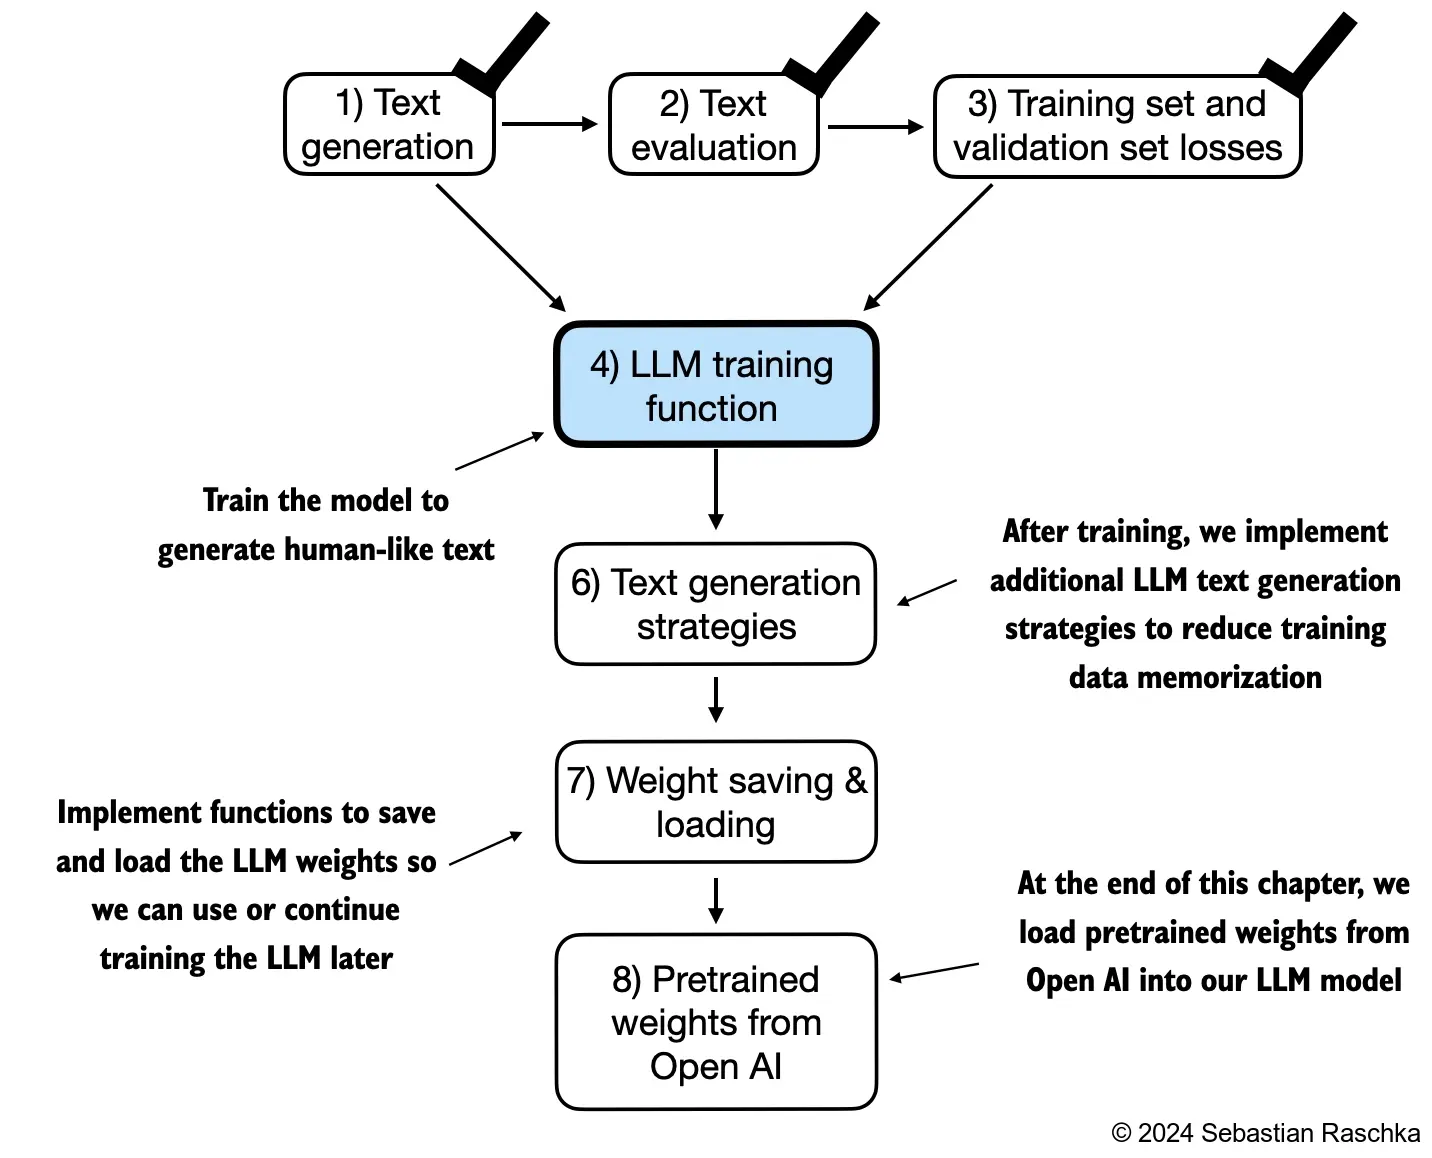

# **# Training an LLM**

In this section, we finally implement the code for training the LLM
We focus on a simple training function

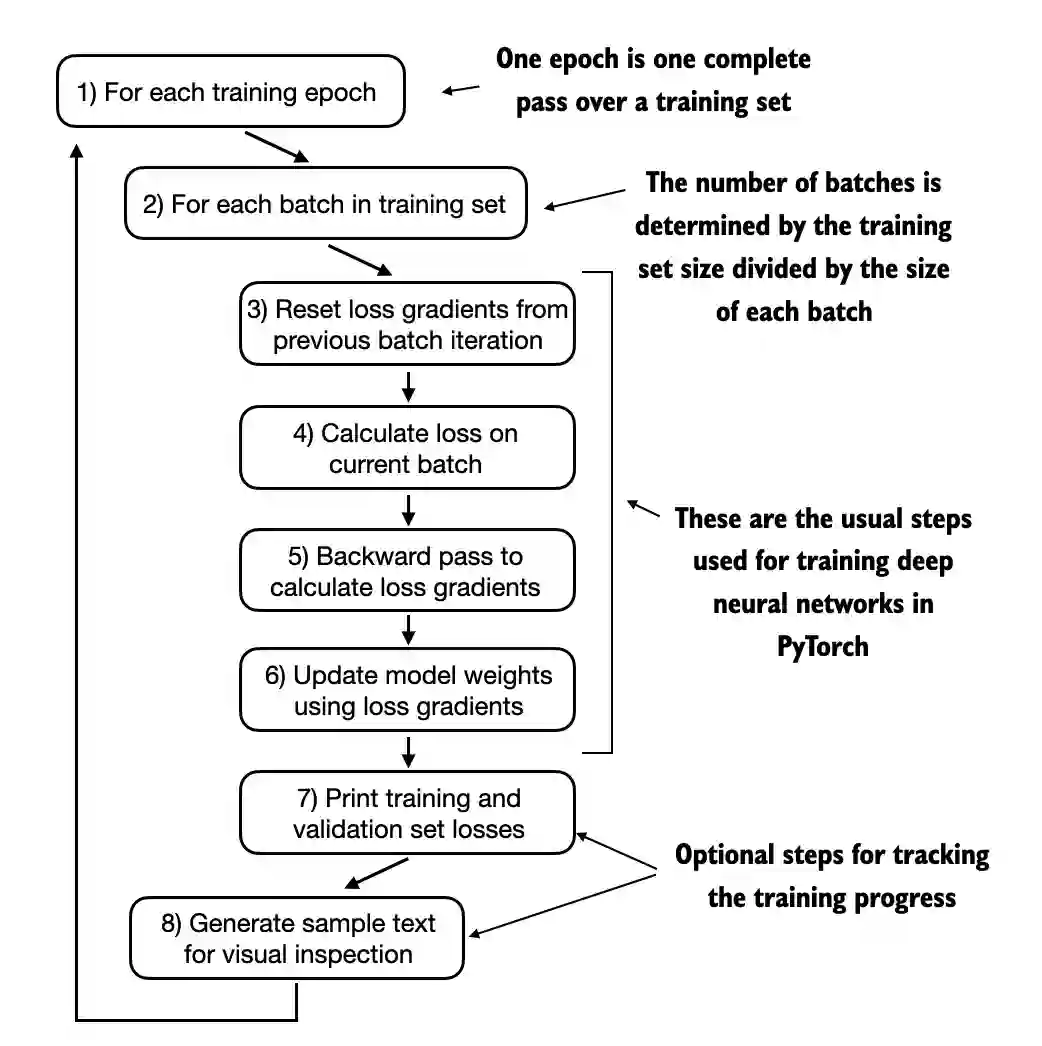

In [31]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [33]:
# Note:
# Uncomment the following code to calculate the execution time
# import time
# start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 50
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.818, Val loss 9.930
Ep 1 (Step 000005): Train loss 8.066, Val loss 8.336
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.623, Val loss 7.053
Ep 2 (Step 000015): Train loss 6.047, Val loss 6.605
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.532, Val loss 6.507
Ep 3 (Step 000025): Train loss 5.399, Val loss 6.389
Every effort moves you, and to the to the of the to the, and I had. Gis, and, and, and, and, and, and I had the, and, and, and, and, and, and, and, and, and
Ep 4 (Step 000030): Train loss 4.895, Val loss 6.280
Ep 4 (Step 000035): Train loss 4.648, Val loss 6.304
Every effort moves you.  "I the picture.                    "I"I the picture"I had the the honour of the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 4.023, Val loss 6.165
Every effort moves you know                                         

* Note that you might get slightly different loss values on your computer, which is not a reason for concern if they are roughly similar (a training loss below 1 and a validation loss below 7)
* Small differences can often be due to different GPU hardware and CUDA versions or small changes in newer PyTorch versions
* Even if you are running the example on a CPU, you may observe slight differences; a possible reason for a discrepancy is the differing behavior of nn.Dropout across operating systems, depending on how PyTorch was compiled, as discussed here on the PyTorch issue tracker

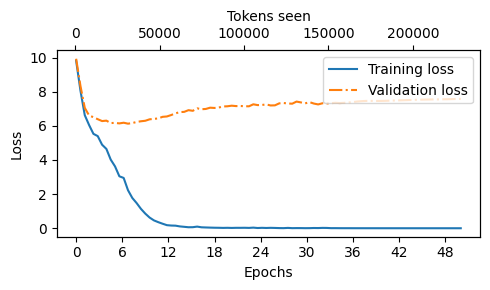

In [34]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

> Looking at the results above, we can see that the model starts out generating incomprehensible strings of words, whereas towards the end, it's able to produce grammatically more or less correct sentences

> However, based on the training and validation set losses, we can see that the model starts overfitting
> If we were to check a few passages it writes towards the end, we would find that they are contained in the training set verbatim -- it simply memorizes the training data

> Later, we will cover decoding strategies that can mitigate this memorization by a certain degree

> Note that the overfitting here occurs because we have a very, very small training set, and we iterate over it so many times
* The LLM training here primarily serves educational purposes; we mainly want to see that the model can learn to produce coherent text
* Instead of spending weeks or months on training this model on vast amounts of expensive hardware, we load pretrained weights later

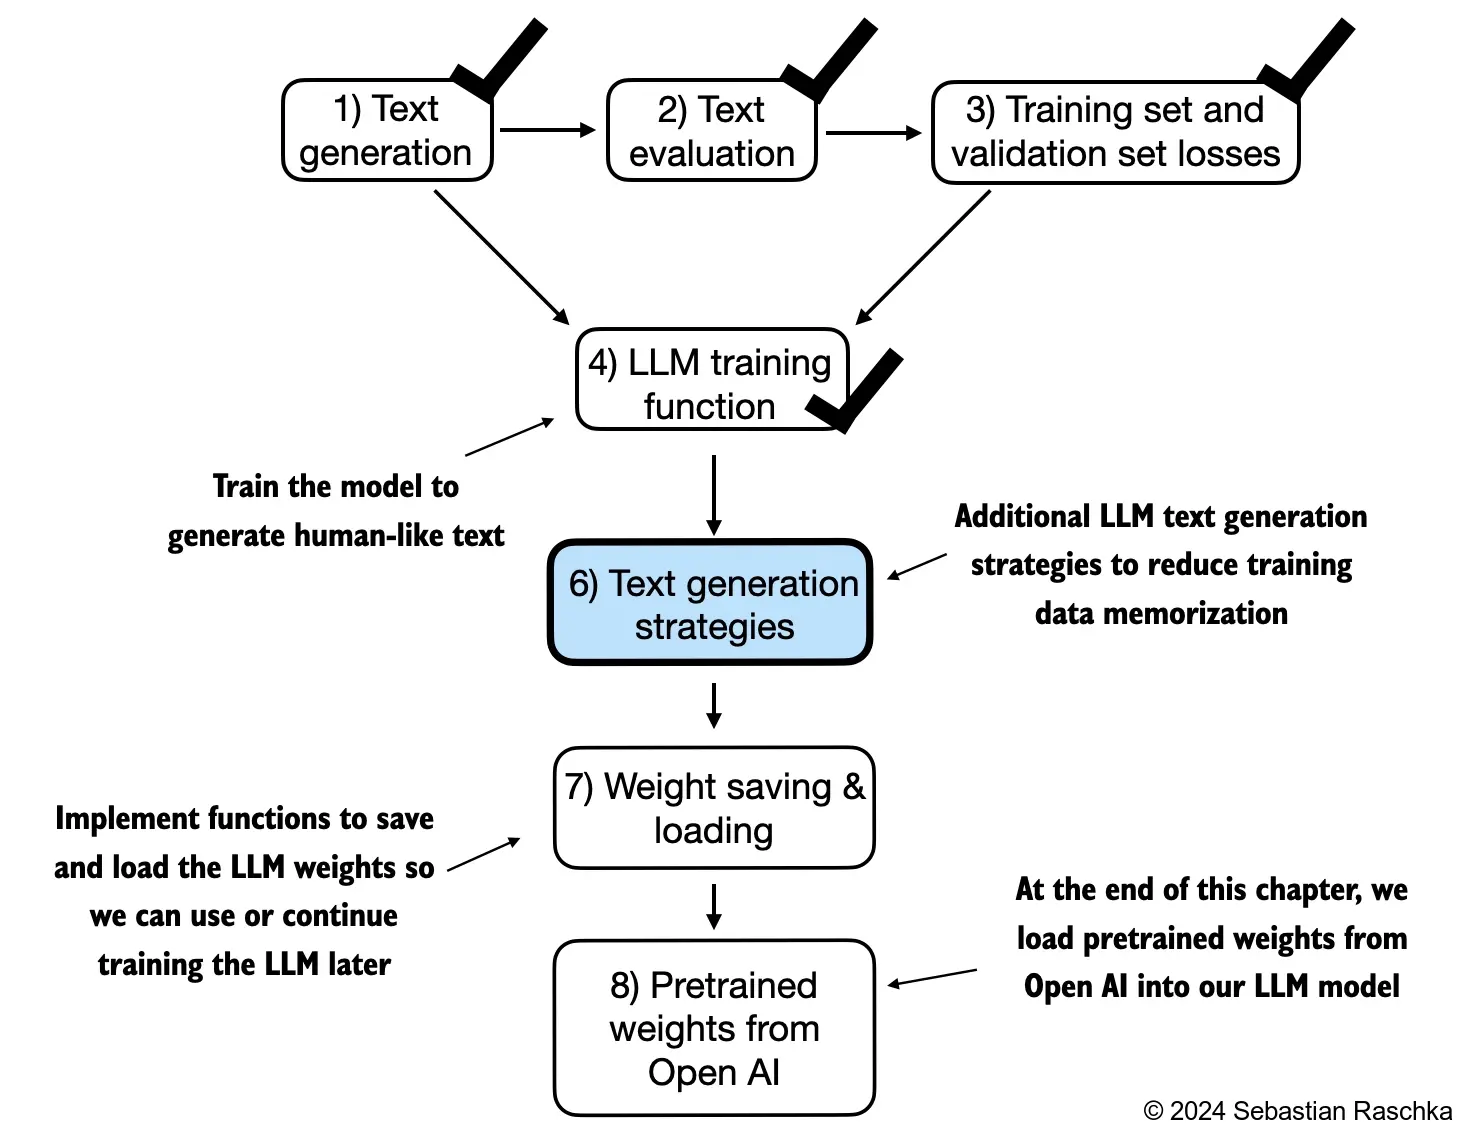

**Decoding strategies to control randomness**

> Inference is relatively cheap with a relatively small LLM as the GPT model we trained above, so there's no need to use a GPU for it in case you used a GPU for training it above

> Using the `generate_text_simple` function (from the previous chapter) that we used earlier inside the simple training function, we can generate new text one word (or token) at a time

> As explained in section 5.1.2, the next generated token is the token corresponding to the largest probability score among all tokens in the vocabulary

In [37]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




* Even if we execute the `generate_text_simple` function above multiple times, the LLM will always generate the same outputs
* We now introduce two concepts, so-called decoding strategies, to modify the `generate_text_simple`: temperature scaling and `top-k` sampling
* These will allow the model to control the randomness and diversity of the generated text

# **Temperature scaling**

* Previously, we always sampled the token with the highest probability as the next token using torch.argmax
* To add variety, we can sample the next token using The torch.multinomial(probs, num_samples=1), sampling from a probability distribution
* Here, each index's chance of being picked corresponds to its probability in the input tensor